In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, BatchNormalization,
                                     MaxPooling2D, GlobalAveragePooling2D, Flatten,
                                     Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import CSVLogger
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json


2025-08-08 04:22:22.860147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 04:22:22.978748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754641343.021362    3459 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754641343.034416    3459 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754641343.131755    3459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
tf.__version__

'2.19.0'

In [ ]:
# Define the model
# model = Sequential([
    
#     Input(shape=(256, 256, 3)),  # 256x256x3
    
#     # Conv Block 1
#     Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_regularizer=l2(5e-4)),  # 128x128x32
#     LeakyReLU(),
#     Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 128x128x32
#     LeakyReLU(),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),  # 63x63x32
    
#     # Conv Block 2
#     Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_regularizer=l2(5e-4)),  # 31x31x64
#     LeakyReLU(),
#     Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 31x31x64
#     LeakyReLU(),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),  # 15x15x64
    
#     # Conv Block 3
#     Conv2D(filters=128, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 15x15x128
#     LeakyReLU(),
#     Conv2D(filters=128, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 15x15x128
#     LeakyReLU(),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),  # 7x7x128
    
#     # Conv Block 4
#     Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 7x7x256
#     LeakyReLU(),
#     MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),  # 3x3x256
    
#     # Conv Block 5
#     Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(5e-4)),  # 3x3x384
#     LeakyReLU(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),  # 1x1x384
    
#     # Flatten & Fully-Connected
#     Flatten(),  # 384
#     Dense(1024, kernel_regularizer=l2(5e-4)),  # 1024
#     LeakyReLU(),
#     Dropout(0.5),
#     Dense(1024, kernel_regularizer=l2(5e-4)),  # 1024
#     LeakyReLU(),
#     Dropout(0.5),
    
#     # Output Layer
#     Dense(1, activation='sigmoid') 
# ])


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,  
#     decay_steps=14390,  
#     decay_rate=0.1,     
#     staircase=True     
# )

inputs = Input(shape=(256, 256, 3))
x = inputs
for filters in [32, 64, 128, 256]:
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(1e-5))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=l2(1e-5))(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # output in [0,1]
model = Model(inputs, outputs)

def ordinal_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def custom_accuracy(y_true, y_pred):
    y_pred_scaled = y_pred * 4
    y_pred_rounded = tf.round(y_pred_scaled)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_rounded), tf.float32))

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss=ordinal_mse,
#     metrics=['mae',custom_accuracy]  
# )

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    # optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
    
    optimizer=optimizer,
    loss=ordinal_mse,
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
)
    
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             

 Total params: 423,873 (1.62 MB)

 Trainable params: 422,657 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [6]:
# Paths to data
train_dir = "train_preprocessed_augmented"
val_dir = "validation_preprocessed"
train_label_file = "augmented_labels.csv"
val_label_file = "trainLabels/validation_updated.csv"

In [7]:
# Read labels
train_df = pd.read_csv(train_label_file)
val_df = pd.read_csv(val_label_file)

In [8]:
# Convert labels to float32 
train_df['level'] = train_df['level'].astype(np.float32)
val_df['level'] = val_df['level'].astype(np.float32)

In [9]:
train_df['level']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
115113    0.0
115114    0.0
115115    0.0
115116    0.0
115117    0.0
Name: level, Length: 115118, dtype: float32

In [10]:
def load_and_preprocess_image(image_path, label):
 
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  #chuyen sang tensor 
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [11]:
def create_dataset(df, img_dir, batch_size=32, shuffle=True):
    # Full paths to images (all images have .jpeg extension)
    image_paths = [os.path.join(img_dir, img_name + ('.jpeg' if not img_name.endswith('.jpeg') else '')) 
                   for img_name in df['image']]
    labels = df['level'].values
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # Map preprocessing function
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
"/home/duc/Documents/DoAn/train_preprocessed_augmented/15_left_aug0.jpeg"

'/home/duc/Documents/DoAn/train_preprocessed_augmented/15_left_aug0.jpeg'

In [13]:
img = tf.io.read_file("train_preprocessed_augmented/15_left_aug0.jpeg")
img = tf.image.decode_jpeg(img, channels=3)  #chuyen sang tensor 
    # Normalize to [0, 1]
img = tf.cast(img, tf.float32) / 255.0
max_value = tf.reduce_min(img)

print("Giá trị lớn nhất trong hình ảnh:", max_value.numpy())


Giá trị lớn nhất trong hình ảnh: 0.0


In [14]:
# Chuyển tensor sang numpy array để xử lý
img_np = img.numpy()
# Chọn tọa độ điểm ảnh muốn kiểm tra 
row, col = 100, 100
# Lấy giá trị RGB của điểm ảnh
pixel_values = img_np[row, col]
# In ma trận điểm ảnh
print("Ma trận RGB của điểm ảnh tại vị trí ({}, {}):".format(row, col))
print("[R, G, B] =", pixel_values)

Ma trận RGB của điểm ảnh tại vị trí (100, 100):
[R, G, B] = [0.49411765 0.46666667 0.5294118 ]


In [15]:
img

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [16]:
train_dataset = create_dataset(train_df, train_dir, batch_size=32, shuffle=True)
val_dataset = create_dataset(val_df, val_dir, batch_size=32, shuffle=False)

Batch shape: Images (32, 256, 256, 3), Labels (32,)
Image dtype: float32, Label dtype: float32
Image value range: [0.0, 1.0]
Labels: [1. 1. 1. 1.]


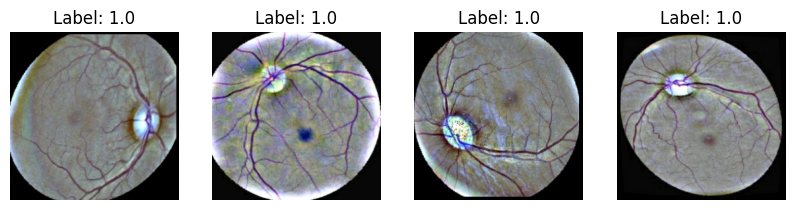

In [17]:
def inspect_dataset(dataset, num_samples=4):
    iterator = iter(dataset)
    images, labels = next(iterator)  # Get one batch
    images = images.numpy()  # Convert to numpy for visualization
    labels = labels.numpy()
    
    print(f"Batch shape: Images {images.shape}, Labels {labels.shape}")
    print(f"Image dtype: {images.dtype}, Label dtype: {labels.dtype}")
    print(f"Image value range: [{images.min()}, {images.max()}]")
    print(f"Labels: {labels[:num_samples]}")
    
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


inspect_dataset(train_dataset)

In [18]:
csv_logger = CSVLogger('training_log.csv', append=False)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1
)


In [19]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[csv_logger, checkpoint,reduce_lr,early_stop],
    verbose=1
)






Epoch 1/30


I0000 00:00:1754617206.065754    5959 service.cc:152] XLA service 0x79db1c016850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754617206.065771    5959 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-07 21:40:06.149583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754617206.503423    5959 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-07 21:40:07.871197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2038', 20 bytes spill stores, 20 bytes spill loads

2025-08-07 21:40:08.837188: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

   1/3598 ━━━━━━━━━━━━━━━━━━━━ 22:14:42 22s/step - loss: 0.3289 - mae: 0.5134

I0000 00:00:1754617226.012213    5959 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3597/3598 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 1.2207 - mae: 0.7037

2025-08-07 21:48:05.902430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1255', 8 bytes spill stores, 8 bytes spill loads



3598/3598 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1.2211 - mae: 0.7038

2025-08-07 21:48:16.477515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_233', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from None to 6.00440, saving model to best_model.keras
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 494s 131ms/step - loss: 2.3902 - mae: 1.1195 - val_loss: 6.0044 - val_mae: 1.9998 - learning_rate: 0.0010
Epoch 2/30
3597/3598 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.2685 - mae: 0.7230
Epoch 2: val_loss did not improve from 6.00440
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 388s 108ms/step - loss: 2.3590 - mae: 1.0787 - val_loss: 6.0063 - val_mae: 2.0000 - learning_rate: 0.0010
Epoch 3/30
3597/3598 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.2855 - mae: 0.7340
Epoch 3: val_loss improved from 6.00440 to 6.00071, saving model to best_model.keras
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 387s 108ms/step - loss: 2.3866 - mae: 1.1022 - val_loss: 6.0007 - val_mae: 1.9989 - learning_rate: 0.0010
Epoch 4/30
3597/3598 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.2925 - mae: 0.7399
Epoch 4: val_loss did not improve from 6.00071
3598/3598 ━━━━━━━━━━━━━━━━━━━━ 388s 108ms/step - loss: 2.3866 - mae: 1.1

In [20]:
print("==== val_df (first 10 rows) ====")
print(val_df[['image', 'level']].head(10))


==== val_df (first 10 rows) ====
         image  level
0  17123_right    0.0
1  12616_right    0.0
2    6541_left    0.0
3  14418_right    0.0
4   39598_left    0.0
5   7947_right    0.0
6  44168_right    0.0
7  17591_right    0.0
8   7819_right    0.0
9  33978_right    0.0


In [30]:
model = tf.keras.models.load_model(
    "best_model.keras",
    custom_objects={'ordinal_mse': ordinal_mse,
                    }
)
y_pred_probs = model.predict(val_dataset)
y_pred_scaled = y_pred_probs * 4  # Scale từ [0, 1] lên [0, 4]
y_pred_clipped = np.clip(y_pred_scaled, 0, 4)
y_pred = np.round(y_pred_clipped.flatten()).astype(int)
y_true=val_df['level'].values
for i in range(100, 110):
    print(f"True: {y_true[i]} | Raw Predicted: {y_pred_probs[i][0]:.4f} | Final Predicted: {y_pred[i]}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4
True: 0.0 | Raw Predicted: 1.0000 | Final Predicted: 4


In [22]:
y_pred_probs

array([[0.0008739 ],
       [0.00087102],
       [0.00087043],
       [0.00086671],
       [0.00087148],
       [0.00087454],
       [0.00087102],
       [0.0008701 ],
       [0.0008777 ],
       [0.00086702],
       [0.00086756],
       [0.00087383],
       [0.00087333],
       [0.00087323],
       [0.0008693 ],
       [0.00086919],
       [0.00087663],
       [0.00086553],
       [0.000871  ],
       [0.0008723 ],
       [0.00087009],
       [0.00087231],
       [0.00086919],
       [0.00086958],
       [0.00086671],
       [0.00087196],
       [0.00086836],
       [0.0008715 ],
       [0.00086665],
       [0.00086705],
       [0.00087624],
       [0.000874  ],
       [0.00086539],
       [0.00087461],
       [0.00086656],
       [0.0008698 ],
       [0.00087034],
       [0.00087335],
       [0.00087385],
       [0.00087008],
       [0.00086971],
       [0.00087387],
       [0.00086989],
       [0.00087102],
       [0.00086671],
       [0.00087686],
       [0.00086781],
       [0.000

In [23]:
for i in range(990,1000):
    print(f"True: {y_true[i]} | Predicted: {y_pred_probs[i][0]:.4f}")

True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009
True: 4.0 | Predicted: 0.0009


In [24]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.2


In [25]:
def preprocess_single_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])  # nếu cần resize
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    img = tf.expand_dims(img, axis=0)  # Thêm batch dimension: (1, 256, 256, 3)
    return img

In [26]:
# Đường dẫn đến ảnh cần dự đoán
image_path = 'validation_preprocessed/6096_right.jpeg'

# Xử lý ảnh
img_tensor = preprocess_single_image(image_path)

# Dự đoán
y_pred_prob = model.predict(img_tensor)[0][0]  # Trích giá trị đầu ra

# Làm tròn và clip (ràng buộc trong khoảng 0–4)
y_pred_label = int(np.clip(round(y_pred_prob), 0, 4))

print(f"Raw prediction: {y_pred_prob}")
print(f"Predicted label: {y_pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Raw prediction: 0.0008699532481841743
Predicted label: 0


In [ ]:
# !ipynb-py-convert structure_model.ipynb plot.py

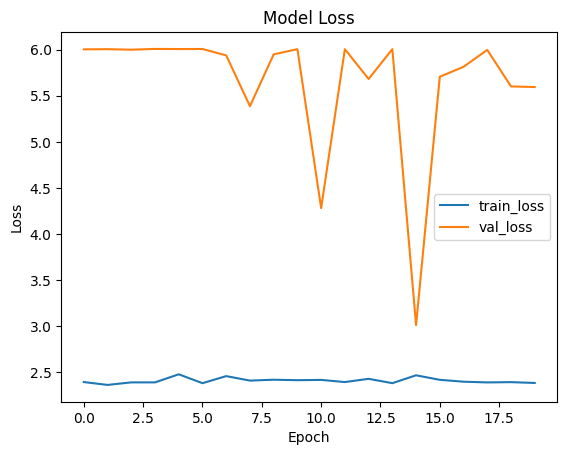

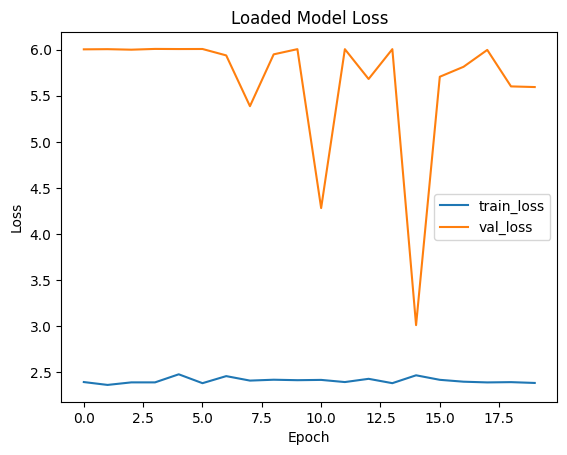

In [28]:

# Save history to JSON
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# To load and view history later
with open('history.json', 'r') as f:
    loaded_history = json.load(f)
    plt.plot(loaded_history['loss'], label='train_loss')
    plt.plot(loaded_history['val_loss'], label='val_loss')
    plt.title('Loaded Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()